### Recommender systems

1. Collaborative Filtering (User-Based):

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Sample data: user ratings for movies
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3],
    'movie_id': ['A', 'B', 'C', 'A', 'D', 'B', 'C', 'D'],
    'rating': [5, 4, 3, 4, 5, 5, 4, 3]
}
# Create a pandas DataFrame from the sample data
df = pd.DataFrame(data)

# Create a user-item matrix using pivot_table
# Rows are user_id, columns are movie_id, values are ratings
# fillna(0) replaces any missing values (movies not rated by a user) with 0
user_item_matrix = df.pivot_table(index='user_id', columns='movie_id',
                                  values='rating').fillna(0)
print(user_item_matrix)
print("--------------")

# Calculate the cosine similarity between users
# This measures the similarity of their rating patterns
user_similarity = cosine_similarity(user_item_matrix)
# Create a DataFrame from the similarity matrix for easier interpretation
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index,
                                  columns=user_item_matrix.index)
print(user_similarity_df.head())


movie_id    A    B    C    D
user_id                     
1         5.0  4.0  3.0  0.0
2         4.0  0.0  0.0  5.0
3         0.0  5.0  4.0  3.0
--------------
user_id         1         2         3
user_id                              
1        1.000000  0.441726  0.640000
2        0.441726  1.000000  0.331295
3        0.640000  0.331295  1.000000


In [ ]:

# Recommend for a specific user (e.g., user 1)
target_user_id = 1
# Get the similarity scores for the target user, sort in descending order,
# and exclude the user itself
similar_users = user_similarity_df[target_user_id].sort_values(ascending=False)[1:]

# Initialize a dictionary to store recommended movies and their scores
recommended_movies = {}
# Iterate through similar users and their similarity scores
for user, similarity_score in similar_users.items():
    # Only consider users with positive similarity
    if similarity_score > 0:
        # Get movies rated by the similar user but not by the target user
        # We select the row for the similar user and filter for movies
        # where the target user's rating is 0
        rated_by_similar = user_item_matrix.loc[user][user_item_matrix.loc[target_user_id]
                                                      == 0]
        # Iterate through the movies rated by the similar user
        for movie, rating in rated_by_similar[rated_by_similar > 0].items():
            # If the movie is not already in the recommended_movies dictionary,
            # add it with a score of 0
            if movie not in recommended_movies:
                recommended_movies[movie] = 0
            # Add the weighted rating (rating * similarity_score) to the movie's score
            recommended_movies[movie] += rating * similarity_score

# Sort the recommended movies by their scores in descending order
sorted_recommendations = sorted(recommended_movies.items(),
                                key=lambda x: x[1], reverse=True)
# Print the recommendations for the target user
print(f"Recommendations for User {target_user_id}: {sorted_recommendations}")

Recommendations for User 1: [('D', 4.12863052149693)]


2. Content-Based Filtering:

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Sample movie data with genres
movies = {
    'title': ['Movie A', 'Movie B', 'Movie C', 'Movie D'],
    'genres': ['Action, Sci-Fi', 'Comedy, Romance', 'Action, Thriller', 'Sci-Fi, Adventure']
}
# Create a pandas DataFrame from the sample movie data
movies_df = pd.DataFrame(movies)

# Create a TF-IDF vectorizer for the genres
# TF-IDF (Term Frequency-Inverse Document Frequency) is used to
#quantify the importance of words in a document
tfidf = TfidfVectorizer(stop_words='english')
# Fit the vectorizer to the genres and transform the genres into a TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# Calculate the cosine similarity between movies based on their TF-IDF genre vectors
# linear_kernel is a fast way to calculate cosine similarity for TF-IDF matrices
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)
print('----------')

# Function to get content-based recommendations for a given movie title
def get_content_based_recommendations(title, cosine_sim_matrix, df):
    # Get the index of the movie that matches the given title
    idx = df[df['title'] == title].index[0]
    # Get the similarity scores for the given movie with all other movies
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    # Sort the movies based on their similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the top 3 most similar movies (excluding the movie itself)
    sim_scores = sim_scores[1:4]
    # Get the indices of the recommended movies
    movie_indices = [i[0] for i in sim_scores]
    # Return the titles of the recommended movies
    return df['title'].iloc[movie_indices]

# Example: Recommend movies similar to 'Movie A'
print(f"Recommendations for 'Movie A':\n \
{get_content_based_recommendations('Movie A', cosine_sim, movies_df)}")

[[1.         0.         0.35745504 0.60784064]
 [0.         1.         0.         0.        ]
 [0.35745504 0.         1.         0.        ]
 [0.60784064 0.         0.         1.        ]]
----------
Recommendations for 'Movie A':
 3    Movie D
2    Movie C
1    Movie B
Name: title, dtype: object


### Anamoly Detection

https://www.geeksforgeeks.org/machine-learning/anomaly-detection-using-isolation-forest/

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# initialize and fit the model
clf = IsolationForest(contamination=0.1)
clf.fit(X_train)

IsolationForest(contamination=0.1)

In [ ]:
# predict the anomalies in the data
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(y_pred_train)
print(y_pred_test)

[ 1  1  1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1 -1  1
  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1]
[ 1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1]


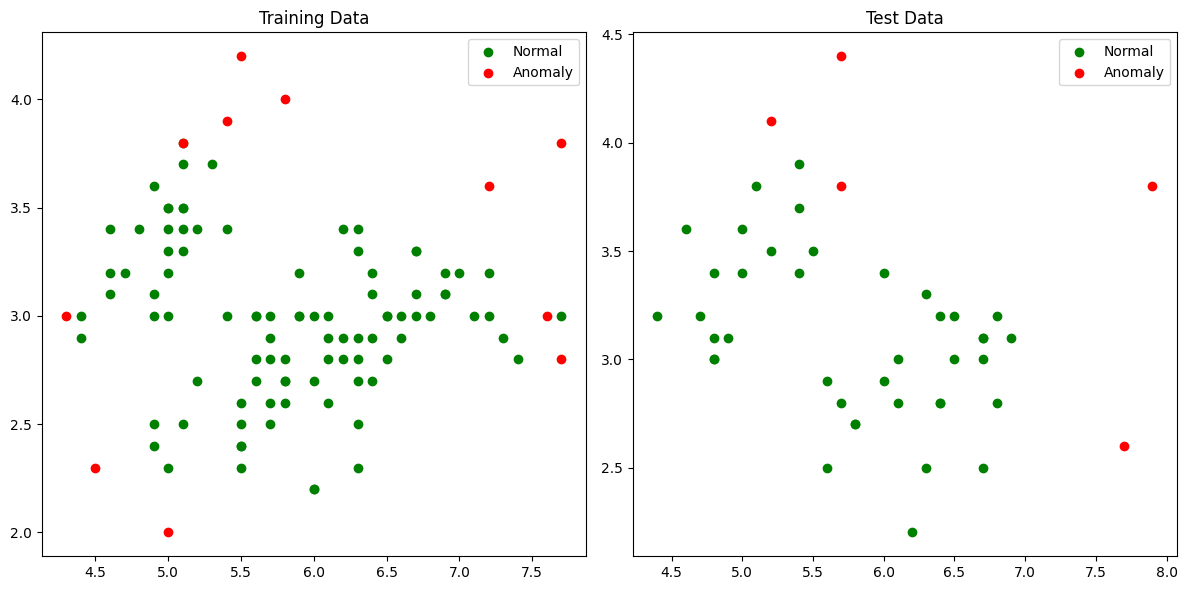

In [ ]:
def create_scatter_plots(X1, y1, title1, X2, y2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Scatter plot for the first set of data
    axes[0].scatter(X1[y1==1, 0], X1[y1==1, 1], color='green', label='Normal')
    axes[0].scatter(X1[y1==-1, 0], X1[y1==-1, 1], color='red', label='Anomaly')
    axes[0].set_title(title1)
    axes[0].legend()

    # Scatter plot for the second set of data
    axes[1].scatter(X2[y2==1, 0], X2[y2==1, 1], color='green', label='Normal')
    axes[1].scatter(X2[y2==-1, 0], X2[y2==-1, 1], color='red', label='Anomaly')
    axes[1].set_title(title2)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# scatter plots
create_scatter_plots(X_train, y_pred_train, 'Training Data', X_test, y_pred_test, 'Test Data')